In [385]:
import dolfin as dl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import scipy.integrate as si
import scipy.optimize as so

import torch
import torch.nn as nn
import torch.nn.functional as F

np.random.seed(2)

# Create the Network

In [446]:
class NN(nn.Module):
    def __init__(self):
        super(NN,self).__init__()
        self.fc1 = nn.Linear(1, 3)
        self.fc2 = nn.Linear(3, 1)
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.uniform_()
            if module.bias is not None:
                module.bias.data.zero_()

        
    def forward(self, x):
        x = torch.tensor([x])
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x.item()
    
    def vector_eval(self, x, m):
        
        if type(x) is not list:
            x = x.tolist()
        
        i = 0
        for xi in x:
            m[i] = self.forward(xi)
            i += 1

# Testing model

# Set device

In [387]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Creating component needed for model

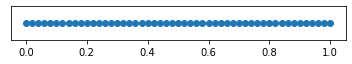

In [388]:
# number of elements for training and testing data
n_train = 50
n_test  = 101

# Create mesh for training and testing data
mesh_train = dl.UnitIntervalMesh(n_train)
mesh_test = dl.UnitIntervalMesh(n_test)

# Create vector version of mesh
mesh_vec = np.linspace(0,1,n_train)

# Define the function space
Vh = dl.FunctionSpace(mesh_train, 'Lagrange', 1)

# Show the mesh
dl.plot(mesh_train)
plt.show()


# Boundary information

In [389]:
def ud_boundary(x, on_boundary):
    return on_boundary

# Define boundary conditions
ud = dl.Constant('0.0')
bc = dl.DirichletBC(Vh, ud, ud_boundary)



# FEM model


In [447]:
class FEM_function:
    def __init__(self, Vh, mesh, bc):
        self.Vh = Vh
        self.coords = np.array(mesh_train.coordinates()).tolist()
        self.bc = bc
        
        # Define variational problem
        self.uh = dl.TrialFunction(Vh)
        self.vh = dl.TestFunction(Vh)
        self.M = dl.assemble( dl.inner(self.uh, self.vh)*dl.dx(self.Vh) )
        
        self.m_vector = dl.Vector()
        self.u = dl.Vector()
        self.p = dl.Vector()
        self.M.init_vector(self.m_vector, 0)
        self.M.init_vector(self.u, 0)
        self.M.init_vector(self.p, 0)
        
        self.ud = None
        self.m_fun = None
        
    def forward_data(self, m, f_expr, noise_lvl, add_noise = False):
        Kform = m * dl.inner(dl.grad(self.uh), dl.grad(self.vh))*dl.dx(self.Vh)
        K, self.f = dl.assemble_system(Kform, f_expr*self.vh*dl.dx(self.Vh), self.bc)
        solver = dl.LUSolver()
        solver.set_operator(K)
        
        solver.solve(self.u, self.f)
        
        self.ud = dl.Vector()
        self.M.init_vector(self.ud, 0)        
        self.ud.axpy(1.,self.u)
        
        if add_noise is True:
            uL2 = dl.norm(self.u, 'L2')
            noise = dl.Vector()
            M.init_vector(noise, 0)   
            noise.set_local( noise_lvl * uL2 *np.random.randn(Vh.dim()))
            self.ud.axpy(1.,noise)
        
        return self.u, self.ud
    
    def extract_m(self, model):
        model.vector_eval(self.coords,self.m_vector)
        return dl.Function(self.Vh, self.m_vector)

    def update_Systems(self, model):
        self.m_fun = self.extract_m(model)
        Kform   = self.m_fun * dl.inner(dl.grad(self.uh), dl.grad(self.vh))*dl.dx(self.Vh)
        Kformt  = self.m_fun * dl.inner(dl.grad(self.vh), dl.grad(self.uh))*dl.dx(self.Vh)
        
        self.K, _ = dl.assemble_system(Kform, dl.Constant(0.)*self.vh*dl.dx(self.Vh), self.bc)
        self.Kt, _ = dl.assemble_system(Kformt, dl.Constant(0.)*self.vh*dl.dx(self.Vh), self.bc)
        
        self.solver = dl.LUSolver()
        self.solver.set_operator(self.K)
        self.solvert = dl.LUSolver()
        self.solvert.set_operator(self.Kt)
       
    def forward(self, model):
        self.update_Systems(model)
        
        self.solver.solve(self.u,self.f)
        
        return self.u
        
    def adjoint(self):
        
        rhs = dl.Vector()
        self.M.init_vector(rhs, 0)
        rhs.axpy(-1., self.M * (self.u - self.ud))
        
        self.solver.solve(self.p, rhs)
        
        return self.p
    
    def cost(self, model):
        c = 0
        _ = self.forward(model)
        
        c = .5 * np.inner(self.M * (self.u - self.ud),(self.u - self.ud))
        
        return c
    def grad(self, model):
        _ = self.forward(model)
        _ = self.adjoint()
        
        u_fun = dl.Function(self.Vh, self.u)
        Fm = dl.assemble(dl.inner(dl.grad(u_fun), dl.grad(self.vh))*dl.dx(self.Vh))
        Jm = dl.assemble(dl.inner(dl.Constant(0.), dl.Constant(0.))*dl.dx(self.Vh))
        
        return (np.inner(self.p, Fm) + Jm) * model.backward()

# Create data

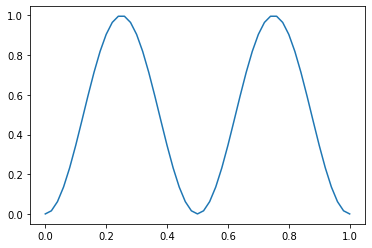

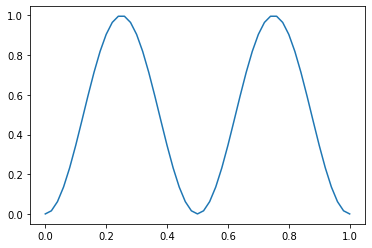

In [448]:
noise_lvl = 0.02

# True m
m_true = dl.Constant(1.)
mx = dl.Constant(0.)

# True solution and derivatives
utrue = dl.Expression('sin(2*pi*x[0]) * sin(2*pi*x[0])', degree=3)
ux = dl.Expression('4 * pi * sin(2*pi*x[0]) * cos(2*pi*x[0])', degree=3)
uxx = dl.Expression('-8*pi*pi*( sin(2*pi*x[0]) * sin(2*pi*x[0]) - cos(2*pi*x[0]) * cos(2*pi*x[0]) )', degree=3)

f = -mx*ux - m*uxx

FEM_model = FEM_function(Vh, mesh = mesh_train, bc = bc)

uapprox, data = FEM_model.forward_data(m_true, f, noise_lvl, add_noise=False)
uapprox = dl.Function(Vh, uapprox)
data = dl.Function(Vh, data)

dl.plot(uapprox)
plt.show()
dl.plot(data)
plt.show()



In [449]:
# Create an instance of the network
model = NN()

# Enable automatic differentiation
for param in model.parameters():
    param.requires_grad = True

print(FEM_model.grad(model))
print(FEM_model.cost(model))

dl.plot(dl.Function(Vh, FEM_model.forward(model)))
plt.show()
dl.plot(FEM_model.m_fun)
plt.show()

AttributeError: 'NN' object has no attribute 'save_for_backward'

# Loss and optimizer

In [444]:
# trust region optimizer with SR1 update
res = so.minimize(fun=FEM_model.cost, jac=FEM_model.grad, x0=model.parameters(), method='BFGS', 
                  options={'gtol': 1e-6, 'disp': True})

TypeError: float() argument must be a string or a real number, not 'generator'

# Train model

In [445]:
torch.autograd.grad(model.forward, model.parameters())


TypeError: 'method' object is not iterable

In [452]:
torch.autograd.backward(model.parameters())

RuntimeError: grad can be implicitly created only for scalar outputs